Input the pickle file, then fit the model in different conditions- acute versus chronic, high diversity vs low diversity of trauma.

In [8]:
import codecs
import sklearn
import glob
import os
import time
import re
from datetime import datetime
import multiprocessing as mp
from multiprocessing import Pool
import pickle
import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
def load_workspace(filename):
 with open(filename, 'rb') as f:
  data_loaded = pickle.load(f)
 return data_loaded
# Example usage:
# loaded_vars = load_workspace('workspace.pkl')
# globals().update(loaded_vars) # This will bring all the variables into the global namespace.

In [10]:

def bootstrap_correlation_ci(series1, series2, n_bootstraps=10000, ci=95):
    indices = np.arange(len(series1))
    correlations = []
    
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_series1 = series1[boot_indices]
        boot_series2 = series2[boot_indices]
        r, _ = stats.pearsonr(boot_series1, boot_series2)
        correlations.append(r)
    
    lower = np.percentile(correlations, (100 - ci) / 2)
    upper = np.percentile(correlations, 100 - (100 - ci) / 2)
    return lower, upper

# And update your function definition to:
def bootstrap_mean_ci(series, n_bootstraps=1000, ci=95):
    means = []
    indices = np.arange(len(series))
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_series = series.iloc[boot_indices]
        means.append(np.mean(boot_series))
    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return lower, upper
def bootstrap_mean_diff_ci(series1, series2, n_bootstraps=10000, ci=95):
    """
    Calculates the bootstrapped confidence interval for the difference between the means of two series.
    """
    series1 = series1.dropna()
    series2 = series2.dropna()
    
    mean_diffs = []
    for _ in range(n_bootstraps):
        boot_series1 = series1.sample(n=len(series1), replace=True)
        boot_series2 = series2.sample(n=len(series2), replace=True)
        mean_diff = boot_series2.mean() - boot_series1.mean()
        mean_diffs.append(mean_diff)
    
    lower = np.percentile(mean_diffs, (100 - ci) / 2)
    upper = np.percentile(mean_diffs, 100 - (100 - ci) / 2)
    return lower, upper

def sigmoid(x,a,b,c):
    y=a+b/(1+np.exp(-c*(x-50)))

    return y

In [11]:
data = load_workspace('data/pklForTheo.pkl')

In [12]:

datForAndrea = pd.read_csv('data/datForAndreaMerged.csv', index_col=0)

print(datForAndrea.shape)
print(datForAndrea.columns)
print("distFromMedQA_lowMC_ltMADCutOff_goodSub:", datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'].sum())
print("distFromMedQAAll_lowMC_ltMADCutOff_goodSub:", datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'].sum())

(418, 48)
Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'Age', 'Race',
       'HLS_ethnicity', 'BirthSex', 'Education', 'LEC-A_6', 'LEC-A_7',
       'LEC-A_8', 'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17',
       'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age',
       'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age', 'trust_rat_mean',
       'trust_rat_std', 'trust_subjLR_bOC', 'trust_subjD_bOC',
       'trust_subjNLL_bOC', 'trust_subjLRTp_bOC', 'trust_subjLR_3prm',
       'trust_subjD_3prm', 'trust_subjp0_3prm', 'trust_subjNLL_3prm',
       'trust_subjLRTp_3prm', 'trust_BIC_bOC', 'trust_BIC_3prm',
       'lott_subjLR_bOC', 'lott_subjD_bOC', 'lott_subjNLL_bOC',
       'lott_subjLRTp_bOC', 'lott_subjLR_3prm', 'lott_subjD_3prm',
       'lott_subjp0_3prm', 'lott_subjNLL_3prm', 'lott_subjLRTp_3prm',
       'lott_BIC_bOC', 'lott_BIC_3prm', 'trustDiscrim_fitOffset',
       'trustDiscrim_fitScale', 'trustDiscrim_fitSlop

In [ ]:
# create Simulated social data and use to ind socially specific params
#only if fit seperately



good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#distFromMedQAAll_lowM

oneLRLOT = pd.read_csv("data/1LRp0D_LOT.csv", index_col=0)
oneLRTRUST = pd.read_csv("data/1LRp0D_TRUST.csv", index_col=0)

#sort by good candidates
oneLRLOT = oneLRLOT.loc[good_candidates]
oneLRTRUST = oneLRTRUST.loc[good_candidates]


import pandas as pd
import statsmodels.api as sm

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_LR': oneLRLOT['subjLR_3prm'],
    'trust_LR': oneLRTRUST['subjLR_3prm']
}).dropna()

# Define predictors and outcome
X = df['lottery_LR']
y = df['trust_LR']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()

print(model.summary())

#for p0

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_p0': oneLRLOT['subjp0_3prm'],
    'trust_p0': oneLRTRUST['subjp0_3prm']
}).dropna()

# Define predictors and outcome
X = df['lottery_p0']
y = df['trust_p0']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()
print(model.summary())
#for D

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_D': oneLRLOT['subjD_3prm'],
    'trust_D': oneLRTRUST['subjD_3prm']
}).dropna()

# Define predictors and outcome
X = df['lottery_D']
y = df['trust_D']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

#make a blank allLrnSumm df
allLrnSumm = pd.DataFrame(index=oneLRTRUST.index)
#now with regression 

""" 
allLrnSumm['subjNLL_3prm_predsoc']= oneLRTRUST['subjNLL_3prm']- (0.4612*oneLRLOT['subjNLL_3prm'] + 0.1847)
allLrnSumm['subjLRTp_3prm_predsoc']= oneLRTRUST['subjLRTp_3prm']- (0.4612*oneLRLOT['subjLRTp_3prm'] + 0.1847)
 """
#this is the depricated simple subtraction methods
""" 
allLrnSumm['subjLR_3prm_socSpec']=allLrnSumm['tr_subjLR_3prm']-allLrnSumm['rw_subjLR_3prm']
allLrnSumm['subjD_3prm_socSpec']=allLrnSumm['tr_subjD_3prm']-allLrnSumm['rw_subjD_3prm']
allLrnSumm['subjp0_3prm_socSpec']=allLrnSumm['tr_subjp0_3prm']-allLrnSumm['rw_subjp0_3prm']
allLrnSumm['subjNLL_3prm_socSpec']=allLrnSumm['tr_subjNLL_3prm']-allLrnSumm['rw_subjNLL_3prm']
allLrnSumm['subjLRTp_3prm_socSpec']=allLrnSumm['tr_subjLRTp_3prm']-allLrnSumm['rw_subjLRTp_3prm']
 """

allLrnSumm['rwsubjLR_3prm']= oneLRLOT['subjLR_3prm']
allLrnSumm['rwsubjp0_3prm']= oneLRLOT['subjp0_3prm']
allLrnSumm['rwsubjD_3prm']= oneLRLOT['subjD_3prm']


allLrnSumm['subjLR_3prm']= oneLRTRUST['subjLR_3prm']
allLrnSumm['subjp0_3prm']= oneLRTRUST['subjp0_3prm']
allLrnSumm['subjD_3prm']= oneLRTRUST['subjD_3prm']

allLrnSumm['subjLR_3prm_predsoc']= oneLRTRUST['subjLR_3prm']- (0.4612*oneLRLOT['subjLR_3prm'] + 0.1847)
allLrnSumm['subjD_3prm_predsoc']=  oneLRTRUST['subjD_3prm']- (0.3433*oneLRLOT['subjD_3prm'] + 0.4545)
allLrnSumm['subjp0_3prm_predsoc']= oneLRTRUST['subjp0_3prm']- (0.4498 *oneLRLOT['subjp0_3prm'] + 0.0159)


oneLRLOT



                            OLS Regression Results                            
Dep. Variable:               trust_LR   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     80.05
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           1.94e-17
Time:                        11:35:13   Log-Likelihood:                 37.593
No. Observations:                 363   AIC:                            -71.19
Df Residuals:                     361   BIC:                            -63.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1847      0.015     12.212      0.0

In [14]:
allLrnSumm['subjLR_3prm_predsoc']= oneLRTRUST['subjLR_3prm']- (0.4612*oneLRLOT['subjLR_3prm'] + 0.1847)
allLrnSumm['subjD_3prm_predsoc']=  oneLRTRUST['subjD_3prm']- (0.3433*oneLRLOT['subjD_3prm'] + 0.4545)
allLrnSumm['subjp0_3prm_predsoc']= oneLRTRUST['subjp0_3prm']- (0.4498 *oneLRLOT['subjp0_3prm'] + 0.0159)

In [15]:
#allLrnSumm = pd.read_csv(r'C:\Users\mnand\Desktop\SNE Data Analysis\Scripts\results\BiasOut1LR_ALL.csv', index_col=0)

In [16]:
#desctiptive stats for Social, nonsocial, and socially specific params, using 95% confidence intervals
import numpy as np
import scipy.stats as stats
good_candidates = datForAndrea[datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in allLrnSumm.index]

allLrnSumm = allLrnSumm.loc[valid_candidates]
print(len(allLrnSumm))


#violin plots for all of these

def plot_violin_with_jitter_and_ci(df, n_bootstraps=10000, ci=95, ylim=None, yticks=None, figsize=(6,6)):
    """
    Plots a violin plot with jittered data, mean, and bootstrapped confidence intervals.
    
    Parameters:
    - df: DataFrame, data to plot with each column being a separate dataset.
    - bootstrap_mean_ci: function, used to calculate mean and CI.
    - n_bootstrap: int, number of bootstrap iterations for CI calculation.
    - ci: float, the confidence interval percentage.
    """
    # Set the figure size and create a violin plot
    plt.figure(figsize=figsize)
    
    # Create violin plots for each column
    sns.violinplot(data=df, inner=None, color="0.8", cut=0)
    
    # Add jittered points
    for i, col in enumerate(df.columns):
        # Jittered x positions
        jittered_x = np.random.normal(i, 0.06, size=len(df))
        plt.scatter(jittered_x, df[col], alpha=0.5, color='k', s=10)
        
        # Calculate mean and CI using the provided function
        lower_ci, upper_ci = bootstrap_mean_ci(df[col], n_bootstraps, ci)
        mean=df[col].mean()
        
        # Plot mean and CI
        plt.errorbar(i+.4, mean, yerr=[[mean - lower_ci], [upper_ci - mean]], fmt='d', color='#FF8F00', capsize=5)
    

    # Set the x-axis labels to the column names
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns)
    # Adjust tick parameters to hide tick marks but keep labels
    plt.tick_params(axis='x', length=0)  # Set tick length to 0 for x-axis

    if ylim is not None:
        plt.ylim(ylim)

    # Optionally set custom yticks if provided
    if yticks is not None:
        plt.yticks(yticks)
    
    # Add a horizontal line at zero
    plt.axhline(y=0, color='Gray', linestyle='--')

    # Adjust y-axis ticks to be inside and remove tick labels
    plt.tick_params(axis='y', direction='in', labelleft=False)  # 'labelleft=False' removes the y-axis tick labels
    
    plt.tight_layout()
    plt.savefig(f'dist{i}.svg', format='svg')
    plt.show()

len(allLrnSumm)

297


297

In [17]:

#plot_violin_with_jitter_and_ci(allLrnSumm[['subjLR_3prm','rwsubjLR_3prm','subjLR_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(allLrnSumm[['subjp0_3prm','rwsubjp0_3prm','subjp0_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(allLrnSumm[['subjD_3prm','rwsubjD_3prm','subjD_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])

#plot_violin_with_jitter_and_ci(allLrnSumm[['subj2LR_pre','subj2LR_post']], ylim=[-1.1,1.1], yticks=[-1,0,1])

<span style="font-size: 48px;">1: Trauma Load</span>

In [18]:
qDat = data['qDat']
# Take all qDat columns that start with 'LEC-A'
lec_df = qDat.loc[:, qDat.columns.str.startswith('LEC')]
#lec_df = datForAndrea.loc[:, datForAndrea.columns.str.startswith('LEC')]



#lec_cols_interest = ['LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_16']
ALL_LEC = ['LEC-A_1','LEC-A_2','LEC-A_3','LEC-A_4','LEC-A_5','LEC-A_6', 'LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_12','LEC-A_14','LEC-A_15','LEC-A_16','LEC-A_17']
ALL_LEC_AGE = [
    'LEC-1-FU-Age', 'LEC-2-FU-Age', 'LEC-3-FU-Age', 'LEC-4-FU-Age', 'LEC-5-FU-Age',
    'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age',
    'LEC-11-FU-Age', 'LEC-12-FU-Age', 'LEC-14-FU-Age', 'LEC-15-FU-Age', 'LEC-16-FU-Age', 'LEC-17-FU-Age'
]
lec_cols_interest = ['LEC-A_6', 'LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17']
lec_cols_interest_witness = ['LEC-A_6','LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11','LEC-A_15', 'LEC-A_17']
lec_age_cols = ['LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age']
lec_age_witness = ['LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-15-FU-Age', 'LEC-16-FU-Age']
lec_chronicity_cols = ['LEC-6-FU-Chronicity', 'LEC-7-FU-Chronicity', 'LEC-8-FU-Chronicity', 'LEC-9-FU-Chronicity', 'LEC-10-FU-Chronicity', 'LEC-11-FU-Chronicity', 'LEC-16-FU-Chronicity']


In [19]:
print(data.keys())

dict_keys(['qDat', 'subjs', 'qSumm', 'subj', 'rwlrnDat', 'rwlrnSumm', 'rwlrnEstArr', 'rwlrnOCArr', 'rwlrnEst', 'rwlrnOC', 'lrnDat', 'lrnSumm', 'lrnEstArr', 'lrnOCArr', 'lrnEst', 'lrnOC', 'qDatW2', 'subjsW2', 'qSummW2', 'summScores'])


In [20]:

def experienced(val):
    if pd.isnull(val):
        return 0
    try:
        return 1 if "1" in str(val).split(",") else 0
    except:
        return 0


def experienced_in_childhood(age, val):
    # Return 1 if age < 18 and '1' is anywhere in val (handles comma-separated or other digits)
    try:
        if float(age) < 18 and ('1' in str(val).split(',')):
            return 1
    except:
        pass
    return 0

def witnessed(val):
    if pd.isnull(val):
        return 0
    try:
        return 1 if "2" in str(val).split(",") else 0
    except:
        return 0


def witnessed_and_experienced(val):
    if pd.isnull(val):
        return 0
    try:
        val_set = set(str(val).split(","))
        return 1 if "1" in val_set and "2" in val_set else 0
    except:
        return 0
    

def witnessed_and_exper_child(val, age):
    if pd.isnull(val):
        return 0
    try:
        val_set = set(str(val).split(","))
        return 1 if float(age) < 18 and "1" in val_set and "2" in val_set else 0
    except:
        return 0
    

def witnessed_in_childhood(age, val):
    # Return 1 if age < 18 and '2' is anywhere in val (handles comma-separated or other digits)
    try:
        if float(age) < 18 and ('2' in str(val).split(',')):
            return 1
    except:
        pass
    return 0

def is_chronic(val, exp_val):
    if pd.isnull(val) or pd.isnull(exp_val):
        return 0
    try:
        # Only count as chronic if experienced ("1" in exp_val) and chronicity == 2
        if "1" in str(exp_val).split(",") and float(val) == 2:
            return 1
        else:
            return 0
    except:
        return 0
    
lec_df['LEC-3-FU-Age'] = lec_df['LEC-3-FU-Age'].astype(str).str.replace(r'^7', '', regex=True)



interpersonal_load = lec_df[lec_cols_interest].applymap(experienced).sum(axis=1)

lec_df['interpersonal_load'] = interpersonal_load
lec_df['interpersonal_childhood'] = [
    sum(experienced_in_childhood(row[age_col], row[lec_col]) for age_col, lec_col in zip(lec_age_cols, lec_cols_interest))
    for _, row in lec_df.iterrows()
]

lec_df['IPT_yn'] = (lec_df['interpersonal_load'] > 0).astype(int)

lec_df['IPT_child_yn'] = (lec_df['interpersonal_childhood'] > 0).astype(int)

lec_df['Lec_Total_Childhood'] = [
    sum(
        experienced_in_childhood(row[age_col], row[lec_col])
        for age_col, lec_col in zip(ALL_LEC_AGE, ALL_LEC)
    )
    for _, row in lec_df.iterrows()
]

lec_df['interpersonal_chronicity'] = [
    sum(is_chronic(row[chronicity_col], row[exp_col]) for chronicity_col, exp_col in zip(lec_chronicity_cols, lec_cols_interest))
    for _, row in lec_df.iterrows()
]

# FIX: chronic_childhood_interpersonal should count only chronic events in childhood
lec_df['chronic_childhood_interpersonal'] = [
    sum(
        is_chronic(row[chronicity_col], row[lec_col]) and experienced_in_childhood(row[age_col], row[lec_col])
        for age_col, lec_col, chronicity_col in zip(lec_age_cols, lec_cols_interest, lec_chronicity_cols)
    )
    for _, row in lec_df.iterrows()
]
lec_df['interpersonal_witnessed'] = [
    sum(
        witnessed(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]
#experienced or witnessed
lec_df['experienced_or_witnessed'] = [
    sum(experienced(row[lec_col]) or witnessed(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]

lec_df['experienced_and_witnessed'] = [
    sum(
        witnessed_and_experienced(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]
lec_df['ipt_witnessed_childhood'] = [
    sum(witnessed_in_childhood(row[age_col], row[lec_col]) for age_col, lec_col in zip(lec_age_witness, lec_cols_interest_witness))
    for _, row in lec_df.iterrows()
]

lec_df['experienced_and_witnessed_childhood'] = [
    sum(witnessed_and_exper_child(row[lec_col], row[age_col]) for lec_col, age_col in zip(lec_cols_interest_witness, lec_age_witness))
    for _, row in lec_df.iterrows()
]
lec_df['experienced_and_witnessed_adulthood'] = lec_df['experienced_and_witnessed'] - lec_df['experienced_and_witnessed_childhood']


#now i will try to separate it first to see if the most traumatic event was interpersonal, and then if that event happened in childhood

#if B1 == 7 8 9 10 11 or 16 then interpersonal
lec_df['most_traumatic_interpersonal'] = lec_df['LEC-B1'].apply(lambda x: int(x in [7, 8, 9, 10, 11, 16]))
# now if that event happened in childhood, we can find this by subtracting how many years ago it happened from the age, taken from prolfic_data
lec_df['Age'] = datForAndrea['Age']
#lec_df['most_traumatic_childhood'] = lec_df.apply(lambda row: int(row['most_traumatic_interpersonal'] and (row['Age'] - row['LEC-B2']) <= 18), axis=1)
## find the events that happened in childhood that were chronic, as defined by the columns LEC-XX-FU-Chronicity
#lec_df['chronic_childhood_interpersonal'] =

#convert all 5s to 4s

lec_df['interpersonal_load_trunc'] = lec_df['interpersonal_load'].replace(5, 4)
lec_df['interpersonal_childhood_trunc'] = lec_df['interpersonal_childhood'].replace(5, 4)

lec_df['interpersonal_adult'] = lec_df['interpersonal_load'] - lec_df['interpersonal_childhood']
lec_df['interpersonal_adult_trunc'] = lec_df['interpersonal_load_trunc'] - lec_df['interpersonal_childhood_trunc']


prolific_dataW2 = data['summScores']
ctq_cols = [col for col in prolific_dataW2.columns if col.startswith('CTQ')]
if 'PID' in prolific_dataW2.columns:
    ctq_cols += ['PID']
ctq_df = prolific_dataW2[ctq_cols]

print(ctq_df.head())

CTQTot = ctq_df['CTQ_total']
#CTQTot = ctq_df['good_candidates']


""" 
# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])
ctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]=6-ctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]
# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])
ctq_df['CTQ_total']=ctq_df.sum(axis=1)
ctq_df['CTQ_emotAb']=ctq_df.iloc[:,np.r_[3,8,14,18,25]-1].sum(axis=1)
ctq_df['CTQ_physAb']=ctq_df.iloc[:,np.r_[9,11,12,15,17]-1].sum(axis=1)
ctq_df['CTQ_sexAb']=ctq_df.iloc[:,np.r_[20,21,23,24,27]-1].sum(axis=1)
ctq_df['CTQ_emotNeg']=ctq_df.iloc[:,np.r_[5,7,13,19,28]-1].sum(axis=1)
ctq_df['CTQ_physNeg']=ctq_df.iloc[:,np.r_[1,2,4,6,26]-1].sum(axis=1)
ctq_df['CTQ_minDen']=(ctq_df.iloc[:,np.r_[10,16,22]-1]>4).sum(axis=1)

ctqScored=ctq_df.join(ctq_df.loc[:, 'CTQ_total':])
#also do quality checks to see if the IPTLoad we imputed and the CTQ are correlated
 """

C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/701028805.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['LEC-3-FU-Age'] = lec_df['LEC-3-FU-Age'].astype(str).str.replace(r'^7', '', regex=True)
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/701028805.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['interpersonal_load'] = interpersonal_load
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/701028805.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                          CTQ_total  CTQ_emotAb  CTQ_physAb  CTQ_sexAb  \
PROLIFIC_PID                                                             
55c694e3fdf99b6c4f28595f  40.000000         7.0         7.0        5.0   
55d86f3569dbc30012b6869f  42.000000         5.0         5.0       10.0   
55e7221441988f000b75cc7a  50.666667         9.0         6.0        5.0   
560ce65601c38a0012769e20  43.333333         6.0         5.0        5.0   
56b8de29e1d0a200051517f8  40.666667         5.0         5.0        5.0   

                          CTQ_emotNeg  CTQ_physNeg  CTQ_minDen  
PROLIFIC_PID                                                    
55c694e3fdf99b6c4f28595f     5.000000     5.000000         1.0  
55d86f3569dbc30012b6869f     9.000000     5.000000         0.0  
55e7221441988f000b75cc7a    18.000000     6.666667         0.0  
560ce65601c38a0012769e20     9.333333     7.666667         0.0  
56b8de29e1d0a200051517f8     6.000000     5.000000         3.0  


C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/701028805.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['Age'] = datForAndrea['Age']
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/701028805.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['interpersonal_load_trunc'] = lec_df['interpersonal_load'].replace(5, 4)
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/701028805.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

" \n# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])\nctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]=6-ctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]\n# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])\nctq_df['CTQ_total']=ctq_df.sum(axis=1)\nctq_df['CTQ_emotAb']=ctq_df.iloc[:,np.r_[3,8,14,18,25]-1].sum(axis=1)\nctq_df['CTQ_physAb']=ctq_df.iloc[:,np.r_[9,11,12,15,17]-1].sum(axis=1)\nctq_df['CTQ_sexAb']=ctq_df.iloc[:,np.r_[20,21,23,24,27]-1].sum(axis=1)\nctq_df['CTQ_emotNeg']=ctq_df.iloc[:,np.r_[5,7,13,19,28]-1].sum(axis=1)\nctq_df['CTQ_physNeg']=ctq_df.iloc[:,np.r_[1,2,4,6,26]-1].sum(axis=1)\nctq_df['CTQ_minDen']=(ctq_df.iloc[:,np.r_[10,16,22]-1]>4).sum(axis=1)\n\nctqScored=ctq_df.join(ctq_df.loc[:, 'CTQ_total':])\n#also do quality checks to see if the IPTLoad we imputed and the CTQ are correlated\n "

In [68]:
def correlate_ctq_childhood(lec_df, CTQTot):
    """
    Computes Pearson correlation between CTQ total score and LEC-based childhood trauma load.
    Returns correlation coefficient and p-value.
    """
    import numpy as np
    from scipy.stats import pearsonr

    # Align indices and drop missing
    df = lec_df.copy()
    df = df.loc[df.index.intersection(CTQTot.index)]
    childhood_load = df['interpersonal_childhood_trunc']
    ctq = CTQTot.loc[childhood_load.index]

    # Drop missing values
    valid = (~childhood_load.isna()) & (~ctq.isna())
    childhood_load = childhood_load[valid]
    ctq = ctq[valid]

    corr, pval = pearsonr(childhood_load, ctq)
    print(f"Correlation between CTQ total and LEC childhood trauma load: r={corr:.3f}, p={pval:.3g}")
    return corr, pval

# Example usage:
correlate_ctq_childhood(lec_df, CTQTot)




Correlation between CTQ total and LEC childhood trauma load: r=0.508, p=6.29e-21


(0.5076784596922742, 6.2915516419746315e-21)

In [ ]:

#Change LEC by childhood trauma load and adulthood truama load, as in not binerized as "childhood trauma or not"
#  use them as regressors? 
#chronic vs acute interpersonal trauma?


good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#distFromMedQAAll_lowMC_ltMADCutOff_
good_candidates2 = datForAndrea[datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in lec_df.index]
lec_df = lec_df.loc[valid_candidates]
valid_candidates = [idx for idx in good_candidates if idx in CTQTot.index]
CTQTot = CTQTot.loc[valid_candidates]
#drop NA
CTQTot = CTQTot.dropna()
#lec_df = lec_df.loc[good_candidates]
# Summary stats for trauma load, childhood/adult, and all trauma functions

# 1. Participants with at least one interpersonal trauma
n_total = len(lec_df)
n_interpersonal = (lec_df['interpersonal_load'] > 0).sum()
pct_interpersonal = n_interpersonal / n_total * 100

# 2. Participants with zero interpersonal trauma
n_no_interpersonal = (lec_df['interpersonal_load'] == 0).sum()
pct_no_interpersonal = n_no_interpersonal / n_total * 100

print(f"Participants with ≥1 interpersonal trauma: {n_interpersonal} ({pct_interpersonal:.1f}%)")
print(f"Participants with no interpersonal trauma: {n_no_interpersonal} ({pct_no_interpersonal:.1f}%)")

# 3. Distribution of number of interpersonal traumas
for n in range(1, 6):
    count = (lec_df['interpersonal_load'] == n).sum()
    pct = count / n_total * 100
    print(f"{count} ({pct:.1f}%) participants reported {n} interpersonal traumatic event(s)")

# 4. Childhood vs. adulthood among those with interpersonal trauma
interpersonal_mask = lec_df['interpersonal_load'] > 0
n_childhood = (lec_df['interpersonal_childhood'] > 0).sum()
n_witnessed = (lec_df['interpersonal_witnessed'] > 0).sum()
n_experienced_witnessed = (lec_df['experienced_and_witnessed'] > 0).sum()
n_adulthood = interpersonal_mask.sum() - n_childhood
# 5. Additional summary stats using all trauma functions
def print_group_stats(df, col, label, threshold=0):
    n_total = len(df)
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")

def print_group_stats_ipt(df, col, label, threshold=0):
    n_total = n_interpersonal
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")
only_childhood = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] == 0)
only_adulthood = (lec_df['interpersonal_childhood'] == 0) & (lec_df['interpersonal_adult'] > 0)
both_child_and_adult = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] > 0)

print(f"Only childhood IPT: {only_childhood.sum()} ({only_childhood.sum()/n_total*100:.1f}%)")
print(f"Only adulthood IPT: {only_adulthood.sum()} ({only_adulthood.sum()/n_total*100:.1f}%)")
print(f"Both childhood and adulthood IPT: {both_child_and_adult.sum()} ({both_child_and_adult.sum()/n_total*100:.1f}%)")
print_group_stats_ipt(lec_df, 'interpersonal_childhood', "Any childhood interpersonal trauma")
print_group_stats_ipt(lec_df, 'interpersonal_adult', "Any adulthood-only interpersonal trauma")
print_group_stats(lec_df, 'interpersonal_load', "Any interpersonal trauma")


def print_group_stats_iptw(df, col, label, threshold=0):
    n_total = n_witnessed
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")

def print_group_stats_iptwc(df, col, label, threshold=0):
    n_total = n_experienced_witnessed
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")
print_group_stats_iptw(lec_df, 'interpersonal_witnessed', "Any witnessed interpersonal trauma")
# Fold together mutually exclusive experienced & witnessed IPT groups

mask_both_child = (lec_df['experienced_and_witnessed_childhood'] > 0)
mask_both_adult = (lec_df['experienced_and_witnessed_adulthood'] > 0)

only_child = mask_both_child & ~mask_both_adult
only_adult = mask_both_adult & ~mask_both_child
both = mask_both_child & mask_both_adult

n_experienced_witnessed = (lec_df['experienced_and_witnessed'] > 0).sum()

print(f"Mutually exclusive breakdown among those with any experienced & witnessed IPT:")
print(f"  Only childhood: {only_child.sum()} ({only_child.sum()/n_experienced_witnessed*100:.1f}%)")
print(f"  Only adulthood: {only_adult.sum()} ({only_adult.sum()/n_experienced_witnessed*100:.1f}%)")
print(f"  Both childhood and adulthood: {both.sum()} ({both.sum()/n_experienced_witnessed*100:.1f}%)")

print(f"\nNested (overlapping) stats:")
print_group_stats_iptwc(lec_df, 'experienced_or_witnessed', "Any interpersonal trauma experienced  wiortnessed")
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed', "Any interpersonal trauma both experienced and witnessed")
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed_childhood', "Any interpersonal trauma both experienced and witnessed in childhood")
#subtract those who experienced and witnessed in childhood from those who experienced and witnessed at all to get adult
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed_adulthood', "Any interpersonal trauma both experienced and witnessed in adulthood")

print_group_stats_iptw(lec_df, 'ipt_witnessed_childhood', "Any witnessed trauma in childhood")


# Basic stats for interpersonal chronicity
chronicity = lec_df['interpersonal_chronicity']

print(f"Mean chronicity: {chronicity.mean():.2f}")
print(f"Median chronicity: {chronicity.median():.2f}")
print(f"Std dev chronicity: {chronicity.std():.2f}")
print(f"Min chronicity: {chronicity.min()}")
print(f"Max chronicity: {chronicity.max()}")
print(f"Number with any chronicity (>0): {(chronicity > 0).sum()} / {len(chronicity)} ({(chronicity > 0).mean()*100:.1f}%)")
print(f"Number with zero chronicity: {(chronicity == 0).sum()} / {len(chronicity)} ({(chronicity == 0).mean()*100:.1f}%)")

# Distribution counts
print("Chronicity value counts:")
print(chronicity.value_counts().sort_index())


n_total = len(lec_df)
n_chronic = (lec_df['interpersonal_chronicity'] > 0).sum()
n_ipt = (lec_df['interpersonal_load'] > 0).sum()

print(f"Number with any chronic interpersonal trauma: {n_ipt} ({n_ipt/n_total*100:.1f}%)")
print(f"Number with chronic interpersonal trauma: {n_chronic} ({n_chronic/n_total*100:.1f}%)")
print(f"Number with acute-only interpersonal trauma: {n_ipt-n_chronic} ({(n_ipt-n_chronic)/n_total*100:.1f}%)")

Participants with ≥1 interpersonal trauma: 213 (58.4%)
Participants with no interpersonal trauma: 152 (41.6%)
87 (23.8%) participants reported 1 interpersonal traumatic event(s)
63 (17.3%) participants reported 2 interpersonal traumatic event(s)
44 (12.1%) participants reported 3 interpersonal traumatic event(s)
16 (4.4%) participants reported 4 interpersonal traumatic event(s)
3 (0.8%) participants reported 5 interpersonal traumatic event(s)
Only childhood IPT: 48 (13.2%)
Only adulthood IPT: 118 (32.3%)
Both childhood and adulthood IPT: 47 (12.9%)
Any childhood interpersonal trauma: 95 (44.6%)
Any adulthood-only interpersonal trauma: 165 (77.5%)
Any interpersonal trauma: 213 (58.4%)
Any witnessed interpersonal trauma: 156 (100.0%)
Mutually exclusive breakdown among those with any experienced & witnessed IPT:
  Only childhood: 27 (31.8%)
  Only adulthood: 42 (49.4%)
  Both childhood and adulthood: 16 (18.8%)

Nested (overlapping) stats:
Any interpersonal trauma experienced  wiortnessed

C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/3244550467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1,6)), y=trauma_counts, palette='Blues')


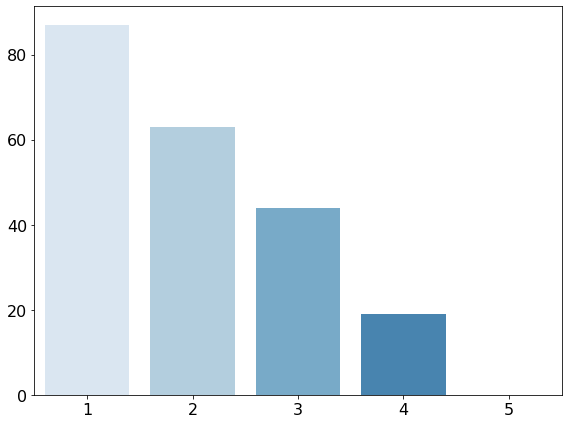

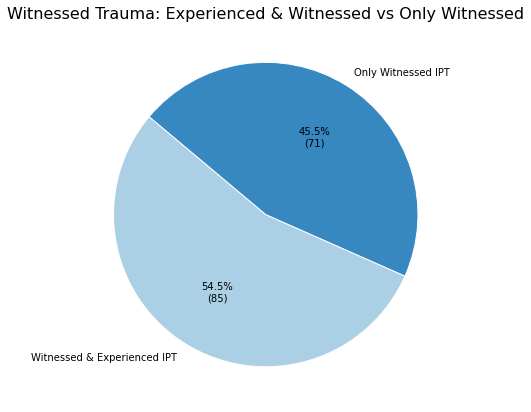

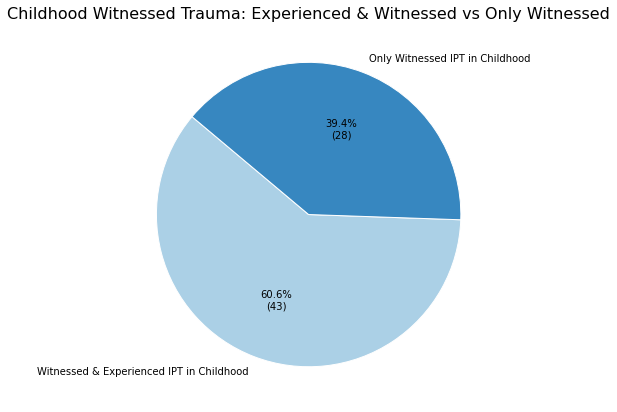

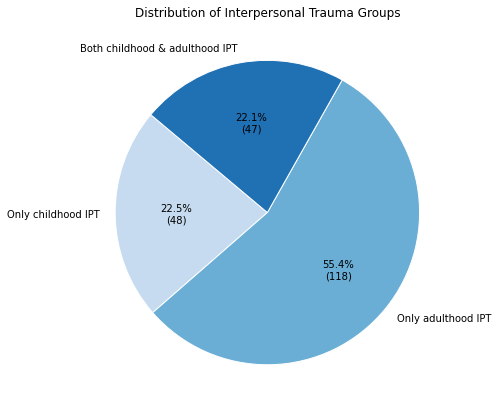

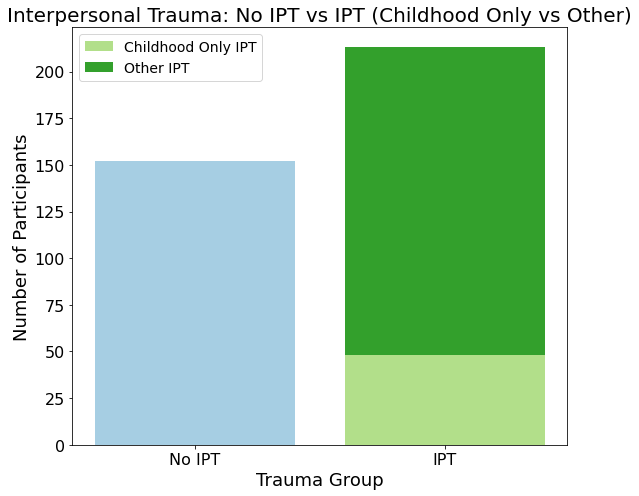

In [23]:

# 2. Bar plot: Distribution of number of interpersonal traumas
plt.figure(figsize=(8,6))
trauma_counts = [(lec_df['interpersonal_load_trunc'] == n).sum() for n in range(1,6)]
sns.barplot(x=list(range(1,6)), y=trauma_counts, palette='Blues')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('dist.svg', format='svg') 
plt.show()

# Pie chart: witnessed trauma split into "witnessed & experienced" vs "only witnessed"

mask_witnessed = lec_df['interpersonal_witnessed'] > 0
mask_experienced_and_witnessed = lec_df['experienced_and_witnessed'] > 0
mask_only_witnessed = mask_witnessed & ~mask_experienced_and_witnessed

pie_labels = [
    "Witnessed & Experienced IPT",
    "Only Witnessed IPT"
]
pie_counts = [
    mask_experienced_and_witnessed.sum(),
    mask_only_witnessed.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts,
    labels=pie_labels,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=2),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Witnessed Trauma: Experienced & Witnessed vs Only Witnessed", fontsize=16)
plt.show()

# Pie chart: witnessed trauma in childhood split into "witnessed & experienced in childhood" vs "only witnessed in childhood"

mask_witnessed_child = lec_df['ipt_witnessed_childhood'] > 0
mask_experienced_and_witnessed_child = lec_df['experienced_and_witnessed_childhood'] > 0
mask_only_witnessed_child = mask_witnessed_child & ~mask_experienced_and_witnessed_child

pie_labels_child = [
    "Witnessed & Experienced IPT in Childhood",
    "Only Witnessed IPT in Childhood"
]
pie_counts_child = [
    mask_experienced_and_witnessed_child.sum(),
    mask_only_witnessed_child.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts_child,
    labels=pie_labels_child,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts_child)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=2),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Childhood Witnessed Trauma: Experienced & Witnessed vs Only Witnessed", fontsize=16)
plt.show()
# Pie chart for mutually exclusive IPT groups with numbers on slices

pie_labels = [
    "Only childhood IPT",
    "Only adulthood IPT",
    "Both childhood & adulthood IPT"
]
pie_counts = [
    only_childhood.sum(),
    only_adulthood.sum(),
    both_child_and_adult.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts,
    labels=pie_labels,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=3),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Distribution of Interpersonal Trauma Groups")
plt.show()
# Bar plot: IPT vs No IPT, with IPT split into "Childhood Only" and "Other" (within IPT group)

import matplotlib.pyplot as plt
import seaborn as sns

# Masks
no_ipt_mask = lec_df['interpersonal_load'] == 0
ipt_mask = lec_df['interpersonal_load'] > 0
child_only_mask = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] == 0) & ipt_mask
other_ipt_mask = ipt_mask & ~child_only_mask

# Counts
n_no_ipt = no_ipt_mask.sum()
n_ipt = ipt_mask.sum()
n_child_only = child_only_mask.sum()
n_other_ipt = other_ipt_mask.sum()

# Stacked bar plot data
ipt_subgroups = [n_child_only, n_other_ipt]

plt.figure(figsize=(8,7))
bars = plt.bar(['No IPT', 'IPT'], [n_no_ipt, n_ipt], color=['#a6cee3', '#1f78b4'])
plt.bar('IPT', n_child_only, color='#b2df8a', label='Childhood Only IPT')
plt.bar('IPT', n_other_ipt, bottom=n_child_only, color='#33a02c', label='Other IPT')

plt.ylabel('Number of Participants', fontsize=18)
plt.xlabel('Trauma Group', fontsize=18)
plt.title('Interpersonal Trauma: No IPT vs IPT (Childhood Only vs Other)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

<span style="font-size: 48px;">2: Trust ratings X IPT</span>

In [24]:
# Filter to good candidates
# Only keep good_candidates that are in lec_df.index

#lec_df = lec_df.loc[good_candidates]
trust_df = datForAndrea.loc[good_candidates]

trust_df = trust_df.loc[lec_df.index]
print(trust_df.columns)

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'Age', 'Race',
       'HLS_ethnicity', 'BirthSex', 'Education', 'LEC-A_6', 'LEC-A_7',
       'LEC-A_8', 'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17',
       'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age',
       'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age', 'trust_rat_mean',
       'trust_rat_std', 'trust_subjLR_bOC', 'trust_subjD_bOC',
       'trust_subjNLL_bOC', 'trust_subjLRTp_bOC', 'trust_subjLR_3prm',
       'trust_subjD_3prm', 'trust_subjp0_3prm', 'trust_subjNLL_3prm',
       'trust_subjLRTp_3prm', 'trust_BIC_bOC', 'trust_BIC_3prm',
       'lott_subjLR_bOC', 'lott_subjD_bOC', 'lott_subjNLL_bOC',
       'lott_subjLRTp_bOC', 'lott_subjLR_3prm', 'lott_subjD_3prm',
       'lott_subjp0_3prm', 'lott_subjNLL_3prm', 'lott_subjLRTp_3prm',
       'lott_BIC_bOC', 'lott_BIC_3prm', 'trustDiscrim_fitOffset',
       'trustDiscrim_fitScale', 'trustDiscrim_fitSlope'],
     

In [25]:


# 1. Compare mean trust ratings: IPT vs no IPT
group_no_ipt = trust_df[lec_df['interpersonal_load'] == 0]['trust_rat_mean']
group_any_ipt = trust_df[lec_df['interpersonal_load'] > 0]['trust_rat_mean']
from scipy.stats import ttest_ind, pearsonr
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
print(f"Mean trust rating (no IPT): {group_no_ipt.mean():.2f} ± {group_no_ipt.std():.2f}")
print(f"Mean trust rating (any IPT): {group_any_ipt.mean():.2f} ± {group_any_ipt.std():.2f}")
print(f"t-test: t={t_stat:.3f}, p={p_val:.3g}")

# Calculate 95% CI for the difference in means
mean_diff = group_any_ipt.mean() - group_no_ipt.mean()
lower_ci, upper_ci = bootstrap_mean_diff_ci(group_no_ipt, group_any_ipt)
print(f"Difference in means (Any IPT - No IPT): {mean_diff:.2f}")
print(f"95% CI for difference: [{lower_ci:.2f}, {upper_ci:.2f}]")


# 2. Correlation: IPT load vs mean trust rating
clean_df = trust_df.copy()
clean_df['interpersonal_load'] = lec_df['interpersonal_load']
clean_df = clean_df[['interpersonal_load', 'trust_rat_mean']].replace([np.inf, -np.inf], np.nan).dropna()
corr, pval = pearsonr(clean_df['interpersonal_load'], clean_df['trust_rat_mean'])
print(f"Correlation (IPT load vs trust): r={corr:.3f}, p={pval:.3g}")




Mean trust rating (no IPT): 4.62 ± 0.96
Mean trust rating (any IPT): 4.33 ± 1.29
t-test: t=2.333, p=0.0202
Difference in means (Any IPT - No IPT): -0.29
95% CI for difference: [-0.52, -0.06]
Correlation (IPT load vs trust): r=-0.074, p=0.157


In [26]:

# Correlation: CTQ vs mean trust rating
clean_df = trust_df.copy()
clean_df['CTQ'] = CTQTot
clean_df = clean_df[['CTQ', 'trust_rat_mean']].replace([np.inf, -np.inf], np.nan).dropna()
corr, pval = pearsonr(clean_df['CTQ'], clean_df['trust_rat_mean'])
print(f"Correlation (CTQvs trust): r={corr:.3f}, p={pval:.3g}")



Correlation (CTQvs trust): r=0.013, p=0.823


<span style="font-size: 24px;">Trust ratings X wit+exp IPT</span>

In [27]:

# 1. Compare mean trust ratings: IPT experienced or witnessed vs no experience or witnessIPT
group_no_ipt = trust_df[lec_df['experienced_or_witnessed'] == 0]['trust_rat_mean']
group_any_ipt = trust_df[lec_df['experienced_or_witnessed'] > 0]['trust_rat_mean']
from scipy.stats import ttest_ind, pearsonr
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
print(f"Mean trust rating (no exp/wit IPT): {group_no_ipt.mean():.2f} ± {group_no_ipt.std():.2f}")
print(f"Mean trust rating (any exp/wit IPT): {group_any_ipt.mean():.2f} ± {group_any_ipt.std():.2f}")
print(f"t-test: t={t_stat:.3f}, p={p_val:.3g}")


# 1. Compare mean trust ratings: IPT witnessed only (no direct experience) vs no experience or witnessIPT
mask_no_witnessed = lec_df['interpersonal_witnessed'] == 0
mask_no_experienced = lec_df['interpersonal_load'] == 0
group_no_ipt = trust_df[mask_no_witnessed & mask_no_experienced]['trust_rat_mean']

mask_only_witnessed = (lec_df['interpersonal_witnessed'] > 0) & (lec_df['interpersonal_load'] == 0)
group_any_ipt = trust_df[mask_only_witnessed]['trust_rat_mean']
from scipy.stats import ttest_ind, pearsonr
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
print(f"Mean trust rating (no exp/wit IPT): {group_no_ipt.mean():.2f} ± {group_no_ipt.std():.2f}")
print(f"Mean trust rating (no exp, any wit IPT): {group_any_ipt.mean():.2f} ± {group_any_ipt.std():.2f}")
print(f"t-test: t={t_stat:.3f}, p={p_val:.3g}")


Mean trust rating (no exp/wit IPT): 4.55 ± 0.91
Mean trust rating (any exp/wit IPT): 4.41 ± 1.27
t-test: t=1.032, p=0.303
Mean trust rating (no exp/wit IPT): 4.55 ± 0.91
Mean trust rating (no exp, any wit IPT): 4.86 ± 1.10
t-test: t=-1.692, p=0.0927


In [28]:
len(group_no_ipt), len(group_any_ipt)

(114, 38)

C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/4267502046.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


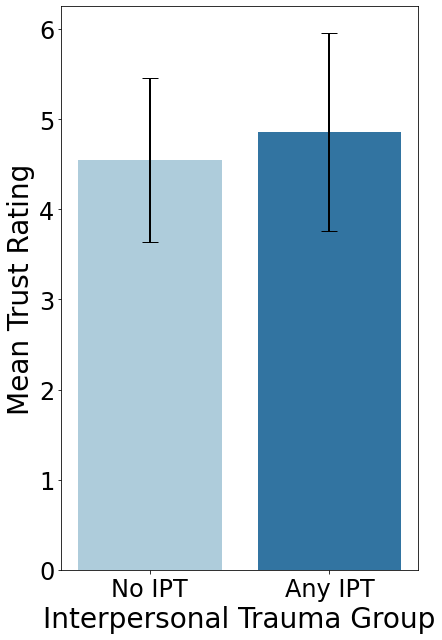

In [29]:
# Visualize mean trust ratings for IPT vs no IPT with large labels
plt.figure(figsize=(6,9))
sns.barplot(
    x=['No IPT', 'Any IPT'],
    y=[group_no_ipt.mean(), group_any_ipt.mean()],
    palette=['#a6cee3', '#1f78b4']
)
plt.errorbar(
    x=[0, 1],
    y=[group_no_ipt.mean(), group_any_ipt.mean()],
    yerr=[group_no_ipt.std(), group_any_ipt.std()],
    fmt='none',
    ecolor='black',
    capsize=8,
    linewidth=2
)
plt.ylabel('Mean Trust Rating', fontsize=28)
plt.xlabel('Interpersonal Trauma Group', fontsize=28)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.show()

<span style="font-size: 48px;">2b: Trust Discrim:</span>

In [30]:
trust_df = datForAndrea.loc[good_candidates]

trust_df = trust_df.loc[lec_df.index]
print(trust_df.columns)

# Hypothesis 2a: Regression of IPT load on trustworthiness discriminability
regression_df_2a = pd.DataFrame({
    'trust_slope': trust_df['trustDiscrim_fitSlope'],
    'interpersonal_load': lec_df['interpersonal_load_trunc']
}).dropna()

X_2a = sm.add_constant(regression_df_2a['interpersonal_load'])
y_2a = regression_df_2a['trust_slope']

model_2a = sm.OLS(y_2a, X_2a).fit()
print("\n--- Hypothesis 2a: Linear Regression (IPT Load vs. Trustworthiness Discriminability) ---")
print(model_2a.summary())

# Hypothesis 2b: Compare groups with and without interpersonal trauma
print("\n--- Hypothesis 2b: Group Comparison (IPT vs. No IPT on Trustworthiness Discriminability) ---")
group_no_ipt_slope = trust_df.loc[lec_df['interpersonal_load'] == 0, 'trustDiscrim_fitSlope'].dropna()
group_any_ipt_slope = trust_df.loc[lec_df['interpersonal_load'] > 0, 'trustDiscrim_fitSlope'].dropna()

# Two-sample t-test
t_stat_2b, p_val_2b = ttest_ind(group_no_ipt_slope, group_any_ipt_slope, nan_policy='omit')
print(f"Mean slope (no IPT): {group_no_ipt_slope.mean():.3f} ± {group_no_ipt_slope.std():.3f}")
print(f"Mean slope (any IPT): {group_any_ipt_slope.mean():.3f} ± {group_any_ipt_slope.std():.3f}")
print(f"t-test: t={t_stat_2b:.3f}, p={p_val_2b:.3g}")

# 95% bootstrap CI for the difference in means
mean_diff_2b = group_any_ipt_slope.mean() - group_no_ipt_slope.mean()
lower_ci_2b, upper_ci_2b = bootstrap_mean_diff_ci(group_no_ipt_slope, group_any_ipt_slope)
print(f"Difference in means (Any IPT - No IPT): {mean_diff_2b:.3f}")
print(f"95% CI for difference: [{lower_ci_2b:.3f}, {upper_ci_2b:.3f}]")

Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'Age', 'Race',
       'HLS_ethnicity', 'BirthSex', 'Education', 'LEC-A_6', 'LEC-A_7',
       'LEC-A_8', 'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17',
       'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age',
       'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age', 'trust_rat_mean',
       'trust_rat_std', 'trust_subjLR_bOC', 'trust_subjD_bOC',
       'trust_subjNLL_bOC', 'trust_subjLRTp_bOC', 'trust_subjLR_3prm',
       'trust_subjD_3prm', 'trust_subjp0_3prm', 'trust_subjNLL_3prm',
       'trust_subjLRTp_3prm', 'trust_BIC_bOC', 'trust_BIC_3prm',
       'lott_subjLR_bOC', 'lott_subjD_bOC', 'lott_subjNLL_bOC',
       'lott_subjLRTp_bOC', 'lott_subjLR_3prm', 'lott_subjD_3prm',
       'lott_subjp0_3prm', 'lott_subjNLL_3prm', 'lott_subjLRTp_3prm',
       'lott_BIC_bOC', 'lott_BIC_3prm', 'trustDiscrim_fitOffset',
       'trustDiscrim_fitScale', 'trustDiscrim_fitSlope'],
     

<span style="font-size: 48px;">3: Trust Ratings x IPT Regression</span>

In [31]:
# Build regression DataFrame with all predictors and outcome, drop missing
regression_df = pd.DataFrame({
    'trust_rat_mean': trust_df['trust_rat_mean'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]
# Unadjusted regression
from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc']])
y_std = scaler.fit_transform(regression_df[['trust_rat_mean']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f},p={model_unadj_std.pvalues[1]:.3g}")
print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (demographics only): {std_beta_adj:.3f},p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())


# Unadjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_childhood_trunc']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nUnadjusted regression standardized beta (IPT and childhood): {std_beta_adj:.3f},p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_childhood_trunc','BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (IPT and childhood with demographics): {std_beta_adj:.3f},p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())

Unadjusted regression standardized beta: 0.039,p=0.573
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3184
Date:                Fri, 30 Jan 2026   Prob (F-statistic):              0.573
Time:                        11:35:19   Log-Likelihood:                -300.65
No. Observations:                 212   AIC:                             605.3
Df Residuals:                     210   BIC:                             612.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

<span style="font-size: 48px;">4: Trust Ratings x Childhood</span>


In [32]:

# 3. Childhood vs adulthood IPT
child_mask = lec_df['interpersonal_childhood'] > 0
adult_mask = (lec_df['interpersonal_load'] > 0) & (lec_df['interpersonal_childhood'] == 0)
group_child = trust_df[child_mask]['trust_rat_mean']
group_adult = trust_df[adult_mask]['trust_rat_mean']
t_stat2, p_val2 = ttest_ind(group_child, group_adult, nan_policy='omit')
print(f"Mean trust rating (childhood IPT): {group_child.mean():.2f} ± {group_child.std():.2f}")
print(f"Mean trust rating (adulthood IPT): {group_adult.mean():.2f} ± {group_adult.std():.2f}")
print(f"t-test (childhood vs adulthood): t={t_stat2:.3f}, p={p_val2:.3g}")

# 4. Effect size (Cohen's d)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

print(f"Cohen's d (childhood vs adulthood): {cohens_d(group_child, group_adult):.3f}")

# 5. Overall sample mean trust rating
print(f"Overall mean trust rating: {trust_df['trust_rat_mean'].mean():.2f} (SD={trust_df['trust_rat_mean'].std():.2f})")

Mean trust rating (childhood IPT): 4.28 ± 1.39
Mean trust rating (adulthood IPT): 4.38 ± 1.20
t-test (childhood vs adulthood): t=-0.593, p=0.554
Cohen's d (childhood vs adulthood): -0.082
Overall mean trust rating: 4.45 (SD=1.17)


<span style="font-size: 48px;">5: Trust x Childhood Regression</span>

In [33]:
#Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'trust_rat_mean': trust_df['trust_rat_mean'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()
regression_df = regression_df[regression_df['interpersonal_load'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['interpersonal_load']])
    y = scaler.fit_transform(df[['trust_rat_mean']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

Childhood IPT: std. β=0.076, p=0.464
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5407
Date:                Fri, 30 Jan 2026   Prob (F-statistic):              0.464
Time:                        11:35:20   Log-Likelihood:                -133.10
No. Observations:                  94   AIC:                             270.2
Df Residuals:                      92   BIC:                             275.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.8

<span style="font-size: 48px;">6: Initial Offer x IPT Load</span>


In [ ]:
#see if there is an effect of chronicity of ipt load on socially specific lr, initial offer, and bias
#then we do the same thing with the childhood trauma questionaire
#good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#merged_df = merged_df.loc[good_candidates]
# Merge on PID to align interpersonal_load and socially specific LR
merged_df = pd.merge(
    allLrnSumm,
    lec_df[['interpersonal_load', 'interpersonal_childhood', 'interpersonal_load_trunc', 'interpersonal_childhood_trunc','interpersonal_chronicity']],
    left_index=True,
    right_index=True
)
valid_candidates = merged_df.index.intersection(good_candidates)
merged_df = merged_df.loc[valid_candidates]

# Group socially-specific initial offers by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjp0_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjp0_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean initial offer (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean initial offer (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: n = {len(group_no_ipt) + len(group_any_ipt)}, t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")


# Calculate 95% CI for the difference in means
mean_diff = group_any_ipt.mean() - group_no_ipt.mean()
lower_ci, upper_ci = bootstrap_mean_diff_ci(group_no_ipt, group_any_ipt)
print(f"Difference in means (Any IPT - No IPT): {mean_diff:.3f}")
print(f"95% CI for difference: [{lower_ci:.3f}, {upper_ci:.3f}]")

merged_df.head()

group_any_ipt


Mean initial offer (no IPT): -0.002 ± 0.630
Mean initial offer (any IPT): -0.003 ± 0.334
Independent samples t-test: n = 297, t=0.01, p=0.992, Cohen's d=0.001
Difference in means (Any IPT - No IPT): -0.001
95% CI for difference: [-0.120, 0.120]


PROLIFIC_PID
60fcd2b146529d02f1566012    0.202170
63ed12d2c25b08ba24fe8a41    0.184871
5d412a9013864b0015b14b31    0.509934
63d842d3e9626bd5fe5c17b1   -0.796517
58016c9f551314000145af58    0.044418
                              ...   
63b6cc23f13731158517f900   -0.161790
63ced96b01986b01ef133497   -0.454470
63f0fb9941434d10e8e4909b    0.369506
5cd10012174fc60016c10ffd   -0.209938
63d2bc12a843f8466a8f83e0    0.256095
Name: subjD_3prm_predsoc, Length: 167, dtype: float64

C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/180914829.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


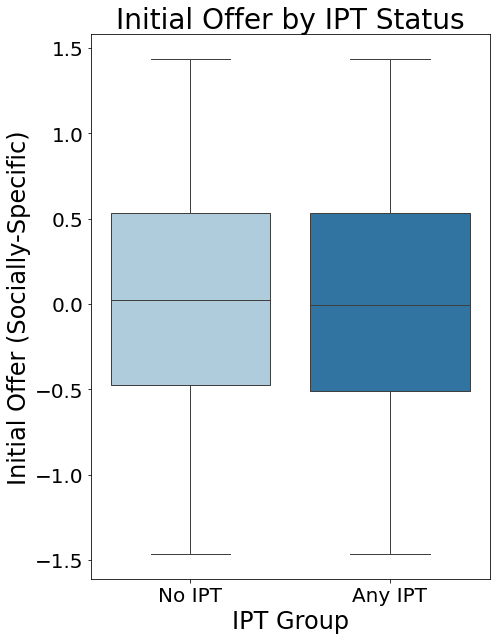

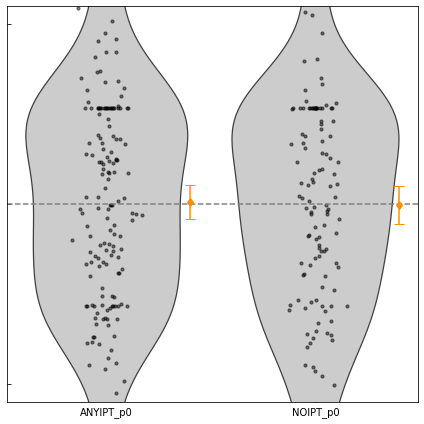

In [35]:

# Calculate SEM
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
violinplot_df = pd.DataFrame({
    
    'NOIPT_p0' : merged_df[merged_df['interpersonal_load'] == 0]['subjp0_3prm_predsoc'],
    'ANYIPT_p0': merged_df[merged_df['interpersonal_load'] > 0]['subjp0_3prm_predsoc'],
})
violinplot_df2 = pd.DataFrame({
    
    'NOIPT_LR' : merged_df[merged_df['interpersonal_load'] == 0]['subjLR_3prm_predsoc'],
    'ANYIPT_LR': merged_df[merged_df['interpersonal_load'] > 0]['subjLR_3prm_predsoc'],
})
violinplot_df3 = pd.DataFrame({
    
    'NOIPT_D' : merged_df[merged_df['interpersonal_load'] == 0]['subjD_3prm_predsoc'],
    'ANYIPT_D': merged_df[merged_df['interpersonal_load'] > 0]['subjD_3prm_predsoc'],
})
# make into a df
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjp0_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjp0_3prm_predsoc']


plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Initial Offer (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Initial Offer by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('P0IPT.svg', format='svg') 
plt.show()


plot_violin_with_jitter_and_ci(violinplot_df[['ANYIPT_p0','NOIPT_p0']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(violinplot_df2[['ANYIPT_LR','NOIPT_LR']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(violinplot_df3[['ANYIPT_D','NOIPT_D']], ylim=[-1.1,1.1], yticks=[-1,0,1])

 # <-- Export as SVG

<span style="font-size: 48px;">7: Initial offer x Interpersonal Load Regression</span>


In [36]:
# Build regression DataFrame for initial offers (socially-specific)
regression_df = pd.DataFrame({
    'init_offer_predsoc': merged_df['subjp0_3prm_predsoc'],
    'trust_rat_mean': trust_df['trust_rat_mean'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

corr, pval = pearsonr(regression_df['trust_rat_mean'], regression_df['init_offer_predsoc'])
print(f"Correlation (trust_rat_mean vs init_offer_predsoc): r={corr:.3f}, p={pval:.3g}")

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['trust_rat_mean']])
y_std = scaler.fit_transform(regression_df[['init_offer_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"trust x  initial offer: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())


# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc']])
y_std = scaler.fit_transform(regression_df[['init_offer_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (w/ race sex etc): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load','interpersonal_childhood']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (with child IPT): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load','interpersonal_childhood', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (with child IPT and demographics): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

Correlation (trust_rat_mean vs init_offer_predsoc): r=0.054, p=0.49
trust x  initial offer: 0.054, p=0.49
Unadjusted regression standardized beta: 0.030, p=0.705

Adjusted regression standardized beta (w/ race sex etc): 0.032, p=0.695

Adjusted regression standardized beta (with child IPT): 0.027, p=0.754

Adjusted regression standardized beta (with child IPT and demographics): 0.025, p=0.776


<span style="font-size: 48px;">8: Initial Offer x Childhood Trauma</span>


In [37]:

# Group socially-specific initial offers by IPT status
group_no_childhood = merged_df[merged_df['interpersonal_childhood'] == 0]['subjp0_3prm_predsoc']
group_any_childhood = merged_df[merged_df['interpersonal_childhood'] > 0]['subjp0_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_childhood = group_no_childhood.mean()
sd_no_childhood = group_no_childhood.std()
mean_any_childhood = group_any_childhood.mean()
sd_any_childhood = group_any_childhood.std()
t_stat, p_val = ttest_ind(group_no_childhood, group_any_childhood, nan_policy='omit')
d = cohens_d(group_no_childhood, group_any_childhood)

print(f"Mean initial offer (no childhood IPT): {mean_no_childhood:.3f} ± {sd_no_childhood:.3f}")
print(f"Mean initial offer (any childhood IPT): {mean_any_childhood:.3f} ± {sd_any_childhood:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")


Mean initial offer (no childhood IPT): 0.002 ± 0.622
Mean initial offer (any childhood IPT): 0.026 ± 0.635
Independent samples t-test: t=-0.29, p=0.770, Cohen's d=-0.040


C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/2604630277.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


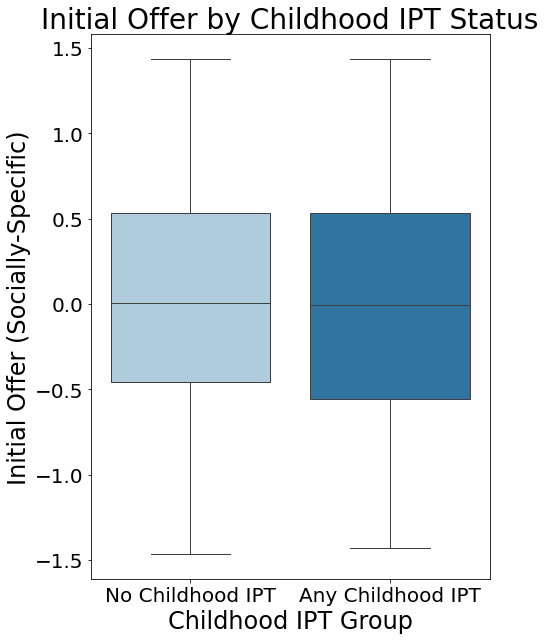

<Figure size 432x288 with 0 Axes>

In [38]:
# Calculate SEM
n_no_childhood = len(group_no_childhood)
n_any_childhood = len(group_any_childhood)
plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No Childhood IPT'] * n_no_childhood + ['Any Childhood IPT'] * n_any_childhood,
    y=pd.concat([group_no_childhood, group_any_childhood]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Initial Offer (Socially-Specific)', fontsize=24)
plt.xlabel('Childhood IPT Group', fontsize=24)
plt.title('Initial Offer by Childhood IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
plt.savefig('P0IPT.svg', format='svg')  # <-- Export as SVG

<span style="font-size: 48px;">9: Initial Offer x Childhood Trauma Regression</span>


In [39]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'init_offer_predsoc': merged_df['subjp0_3prm_predsoc'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age'],
}).dropna()
regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['interpersonal_load_trunc']])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")


# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler


def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: init_offer_predsoc")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: init_offer_predsoc")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")
run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
chronic_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] > 0)
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
acute_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] == 0)
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: init_offer_predsoc")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")


Childhood IPT: std. β=-0.007, p=0.953
Adulthood-only IPT: std. β=0.057, p=0.585
Adult IPT with childhood IPT: std. β=-0.005, p=0.969
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: init_offer_predsoc
Adult IPT without childhood IPT: std. β=0.057, p=0.585
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: init_offer_predsoc
Adult IPT with childhood IPT w/ demos: std. β=0.001, p=0.995
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: init_offer_predsoc
Adult IPT without childhood IPT w/ demos: std. β=0.088, p=0.439
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: init_offer_predsoc
Childhood IPT: std. β=-0.007, p=0.953
Adulthood-only IPT: std. β=0.057, p=0.585
Chronic IPT: std. β=0.012, p=0.909
Acute IPT: std. β=0.078, p=0.504
Chronic Childhood IPT: std. β=0.000, p=0.998
Acute Childhood IPT: std. β=-0.000, p=0.998
Chronic Adulthood IPT: std. β=-0.043, p=0.788


<span style="font-size: 48px;">10: Learning Rate and IPT</span>

In [40]:
# Group socially-specific learning rates by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjLR_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjLR_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean LR (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean LR (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: n = {len(group_no_ipt) + len(group_any_ipt)}, t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

Mean LR (no IPT): -0.018 ± 0.216
Mean LR (any IPT): 0.030 ± 0.233
Independent samples t-test: n = 297, t=-1.81, p=0.071, Cohen's d=-0.213


C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/3017733439.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


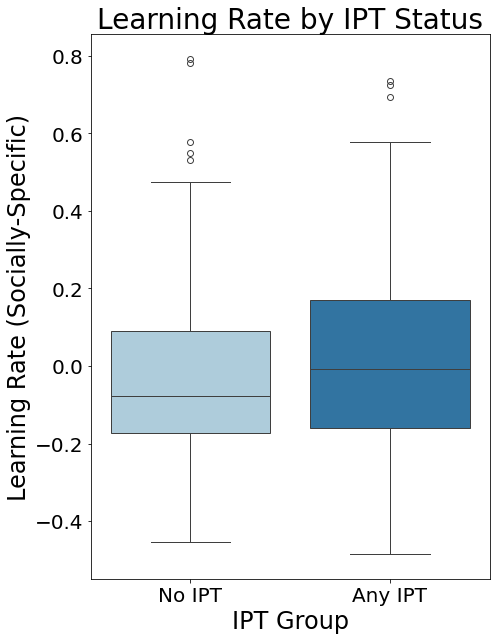

In [41]:
# Visualize mean socially-specific learning rates for IPT vs no IPT
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
sems = [sd_no_ipt / np.sqrt(n_no_ipt), sd_any_ipt / np.sqrt(n_any_ipt)]

plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Learning Rate (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Learning Rate by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('LRIPT.svg', format='svg')  # <-- Export as SVG
plt.show()


In [42]:
# Group socially-specific learning rates by IPT age status (childhood vs adulthood-only)

regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_group = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_group = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_childhood = regression_df[childhood_group]['subjLR_3prm'].mean()
sd_childhood = regression_df[childhood_group]['subjLR_3prm'].std()
mean_adulthood = regression_df[adulthood_group]['subjLR_3prm'].mean()
sd_adulthood = regression_df[adulthood_group]['subjLR_3prm'].std()
t_stat, p_val = ttest_ind(regression_df[childhood_group]['subjLR_3prm'], regression_df[adulthood_group]['subjLR_3prm'], nan_policy='omit')
d = cohens_d(regression_df[childhood_group]['subjLR_3prm'], regression_df[adulthood_group]['subjLR_3prm'])

print(f"Mean LR (childhood IPT): {mean_childhood:.3f} ± {sd_childhood:.3f}")
print(f"Mean LR (adulthood IPT): {mean_adulthood:.3f} ± {sd_adulthood:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

Mean LR (childhood IPT): 0.037 ± 0.231
Mean LR (adulthood IPT): 0.024 ± 0.237
Independent samples t-test: t=0.37, p=0.713, Cohen's d=0.058


In [43]:


# adult with childhood trauma
adulthood_w_childhood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] > 0)

#adult without childhood trauma
adulthood_wo_childhood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)
    
adulthood_w_childhood = regression_df[adulthood_w_childhood_mask]['subjLR_3prm']
adulthood_wo_childhood = regression_df[adulthood_wo_childhood_mask]['subjLR_3prm']

adulthood_w_childhood.mean(), adulthood_wo_childhood.mean()
print(f"Mean LR (adulthood IPT with childhood IPT): {adulthood_w_childhood.mean():.3f} ± {adulthood_w_childhood.std():.3f}")
print(f"Mean LR (adulthood IPT without childhood IPT): {adulthood_wo_childhood.mean():.3f} ± {adulthood_wo_childhood.std():.3f}")
# Independent samples t-test
print(adulthood_w_childhood.shape, adulthood_wo_childhood.shape)


t_stat, p_val = ttest_ind(adulthood_w_childhood, adulthood_wo_childhood, nan_policy='omit')
print(f"t-test: t={t_stat:.2f}, p={p_val:.3f}")

Mean LR (adulthood IPT with childhood IPT): 0.037 ± 0.231
Mean LR (adulthood IPT without childhood IPT): 0.024 ± 0.237
(71,) (95,)
t-test: t=0.37, p=0.713


<span style="font-size: 48px;">11: IPT X Learning Rate Regression</span>


In [44]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'LR_predsoc': merged_df['subjLR_3prm_predsoc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load']])
y_std = scaler.fit_transform(regression_df[['LR_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (interpersonal_load): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

Unadjusted regression standardized beta: -0.123, p=0.113

Adjusted regression standardized beta (interpersonal_load): -0.172, p=0.0324


<span style="font-size: 48px;">12: Social alone x LRs</span>


In [45]:
# Build regression DataFrame for Learning Rates (social ALONE)
regression_df = pd.DataFrame({
    'subjLR_3prm': oneLRTRUST['subjLR_3prm'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load']])
y_std = scaler.fit_transform(regression_df[['subjLR_3prm']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (interpersonal_load): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())

Unadjusted regression standardized beta: -0.125, p=0.0696
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.326
Date:                Fri, 30 Jan 2026   Prob (F-statistic):             0.0696
Time:                        11:35:26   Log-Likelihood:                -299.15
No. Observations:                 212   AIC:                             602.3
Df Residuals:                     210   BIC:                             609.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

<span style="font-size: 48px;">13: Child IPT X Social Alone </span>


In [46]:

regression_df = pd.DataFrame({
    'subjLR_3prm': oneLRTRUST['subjLR_3prm'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

# Group social alone learning rates by childhood IPT status
group_no_ipt = regression_df[regression_df['interpersonal_childhood'] == 0]['subjLR_3prm']
group_any_ipt = regression_df[regression_df['interpersonal_childhood'] > 0]['subjLR_3prm']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean LR (no child IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean LR (any child IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")



Mean LR (no child IPT): 0.261 ± 0.238
Mean LR (any child IPT): 0.305 ± 0.250
Independent samples t-test: t=-1.51, p=0.132, Cohen's d=-0.181


<span style="font-size: 48px;">14: Child IPT X Learning Rate Regression</span>


Childhood IPT: std. β=-0.219, p=0.066


Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Adulthood-only IPT: std. β=-0.048, p=0.646
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic IPT: std. β=-0.176, p=0.097
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute IPT: std. β=-0.090, p=0.439
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic Childhood IPT: std. β=-0.228, p=0.132
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute Childhood IPT: std. β=-0.189, p=0.356
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic Adulthood IPT: std. β=-0.074, p=0.641
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute Adulthood IPT: std. β=-0.141, p=0.313
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Childhood IPT w/ demos: std. β=-0.258, p=0.034
Predictor(s): ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm
Adulthood-only IPT w/

C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/4293907361.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


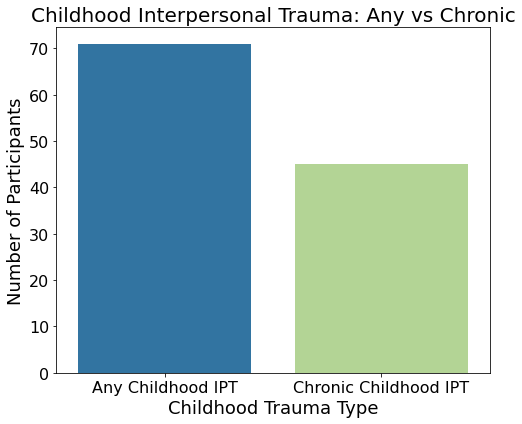

In [47]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")
    #print(model.summary())


# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
chronic_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] > 0)
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
acute_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] == 0)
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")

#of those with chronic trauma, how much had any childhood trauma
import seaborn as sns

# Count participants with any childhood IPT and chronic childhood IPT
n_childhood = (regression_df['interpersonal_childhood_trunc'] > 0).sum()
n_chronic_childhood = (regression_df['chronic_childhood_interpersonal'] > 0).sum()

print(n_childhood)
print(n_chronic_childhood)

plt.figure(figsize=(7,6))
sns.barplot(
    x=['Any Childhood IPT', 'Chronic Childhood IPT'],
    y=[n_childhood, n_chronic_childhood],
    palette=['#1f78b4', '#b2df8a']
)
plt.ylabel('Number of Participants', fontsize=18)
plt.xlabel('Childhood Trauma Type', fontsize=18)
plt.title('Childhood Interpersonal Trauma: Any vs Chronic', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [48]:
#Apparently, a strong predictor of if Adult IPT will be associated with learning rate 
# is whether the individual also experienced childhood IPT

regression_df = pd.DataFrame({
   
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],

    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],

    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],

    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()


# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0) 
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

childhood_only_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['interpersonal_adult_load_trunc'] == 0)
regression_df = regression_df[regression_df['interpersonal_adult_load_trunc'] > 0]

def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())

def run_standardized_reg_child(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_childhood_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())

def run_standardized_reg_child_demos(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_childhood_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")

run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")

run_standardized_reg_child(regression_df[childhood_mask], "Childhood IPT")

run_standardized_reg_child_demos(regression_df[childhood_mask], "Childhood IPT w/ demos")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")

run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")


Adult IPT with childhood IPT: std. β=-0.327, p=0.055
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjLR_3prm
Adult IPT without childhood IPT: std. β=-0.048, p=0.646
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjLR_3prm
Childhood IPT: std. β=-0.268, p=0.120
Predictor(s): ['interpersonal_childhood_trunc'] | Outcome: subjLR_3prm
Childhood IPT w/ demos: std. β=-0.414, p=0.018
Predictor(s): ['interpersonal_childhood_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm
Adult IPT with childhood IPT w/ demos: std. β=-0.255, p=0.171
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm
Adult IPT without childhood IPT w/ demos: std. β=-0.122, p=0.278
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm


C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/2584339032.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/2584339032.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/2584339032.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_child(regression_df[childhood_mask], "Childhood IPT")
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/2584339032.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_child_demos(regression_df[childhood_mask], "Childhood IPT w/ demos")
C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/2584339032.py:91: 

In [49]:
len(regression_df[adulthood_mask])

C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/1071498377.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(regression_df[adulthood_mask])


95

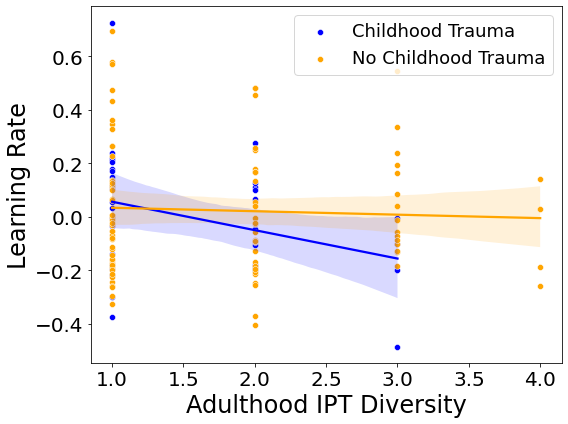

71 95


In [50]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[childhood_mask, 'subjLR_3prm'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[adulthood_mask, 'subjLR_3prm'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[childhood_mask, 'subjLR_3prm'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[adulthood_mask, 'subjLR_3prm'],
    scatter=False, color='orange'
)

plt.xlabel('Adulthood IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('adultCtrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

print(childhood_mask.sum(), adulthood_mask.sum())

Mean LR (chronic childhood IPT): -0.034 ± 0.204
Mean LR (acute childhood IPT): 0.062 ± 0.263
t-test: t=-1.19, p=0.241, Cohen's d=-0.425


C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/784262863.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


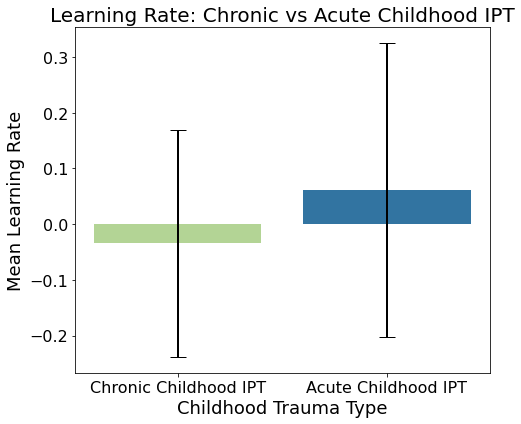

In [51]:
# Chronic childhood IPT: chronic_childhood_interpersonal > 0
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0

# Acute childhood IPT: interpersonal_childhood_trunc > 0 and chronic_childhood_interpersonal == 0
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)

# Compare mean learning rates for chronic vs acute childhood IPT
group_chronic = regression_df[chronic_child_mask]['subjLR_3prm']
group_acute = regression_df[acute_child_mask]['subjLR_3prm']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

mean_chronic = group_chronic.mean()
sd_chronic = group_chronic.std()
mean_acute = group_acute.mean()
sd_acute = group_acute.std()
t_stat, p_val = ttest_ind(group_chronic, group_acute, nan_policy='omit')
d = cohens_d(group_chronic, group_acute)

print(f"Mean LR (chronic childhood IPT): {mean_chronic:.3f} ± {sd_chronic:.3f}")
print(f"Mean LR (acute childhood IPT): {mean_acute:.3f} ± {sd_acute:.3f}")
print(f"t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,6))
sns.barplot(
    x=['Chronic Childhood IPT', 'Acute Childhood IPT'],
    y=[mean_chronic, mean_acute],
    palette=['#b2df8a', '#1f78b4']
)
plt.errorbar(
    x=[0, 1],
    y=[mean_chronic, mean_acute],
    yerr=[sd_chronic, sd_acute],
    fmt='none',
    ecolor='black',
    capsize=8,
    linewidth=2
)
plt.ylabel('Mean Learning Rate', fontsize=18)
plt.xlabel('Childhood Trauma Type', fontsize=18)
plt.title('Learning Rate: Chronic vs Acute Childhood IPT', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [52]:
print(allLrnSumm.columns)

Index(['rwsubjLR_3prm', 'rwsubjp0_3prm', 'rwsubjD_3prm', 'subjLR_3prm',
       'subjp0_3prm', 'subjD_3prm', 'subjLR_3prm_predsoc',
       'subjD_3prm_predsoc', 'subjp0_3prm_predsoc'],
      dtype='object')


In [53]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'subjD_3prm':allLrnSumm['subjD_3prm_predsoc'],
    'subjp0_3prm': allLrnSumm['subjp0_3prm_predsoc'],
    'CTQ' :CTQTot,
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['CTQ']])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df, "CTQTot")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['CTQ', 'BirthSex', 'Race', 'HLS_ethnicity','Age']])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(model.summary())

run_standardized_reg_demo(regression_df, "CTQ + Demographics")

CTQTot: std. β=0.117, p=0.046
CTQ + Demographics: std. β=0.093, p=0.129
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.690
Date:                Fri, 30 Jan 2026   Prob (F-statistic):              0.137
Time:                        11:35:28   Log-Likelihood:                -411.50
No. Observations:                 293   AIC:                             835.0
Df Residuals:                     287   BIC:                             857.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [54]:
from sklearn.preprocessing import StandardScaler

# Convert categorical variables to dummies
df = regression_df.copy()


outcomes = ['subjLR_3prm', 'subjD_3prm', 'subjp0_3prm']
predictor = ['CTQ']
predictors = ['CTQ', 'BirthSex', 'Race', 'HLS_ethnicity','Age']

for outcome in outcomes:
    scaler = StandardScaler()
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[[outcome]]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # CTQ standardized beta
    pval = model.pvalues[1]
    print(f"{outcome} ~ CTQ + std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())



for outcome in outcomes:
    scaler = StandardScaler()
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[[outcome]]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # CTQ standardized beta
    pval = model.pvalues[1]
    print(f"{outcome} ~ CTQ + Demographics std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

subjLR_3prm ~ CTQ + std. β=0.117, p=0.046
subjD_3prm ~ CTQ + std. β=0.014, p=0.807


subjp0_3prm ~ CTQ + std. β=0.029, p=0.626
subjLR_3prm ~ CTQ + Demographics std. β=0.093, p=0.129
subjD_3prm ~ CTQ + Demographics std. β=-0.052, p=0.390
subjp0_3prm ~ CTQ + Demographics std. β=0.097, p=0.111


<span style="font-size: 48px;">15: Child IPT X Learning Rate Mixed Effects</span>

In [55]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult': lec_df['interpersonal_adult_trunc'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) | (regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)



                                                df    sum_sq   mean_sq  \
interpersonal_childhood                        1.0  0.010975  0.010975   
interpersonal_adult                            1.0  0.168574  0.168574   
interpersonal_childhood:interpersonal_adult    1.0  0.179548  0.179548   
Residual                                     162.0  8.626689  0.053251   

                                                    F    PR(>F)  
interpersonal_childhood                      0.206097  0.650452  
interpersonal_adult                          3.165630  0.077078  
interpersonal_childhood:interpersonal_adult  3.371728  0.068157  
Residual                                          NaN       NaN  


In [56]:
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    #mask the ipt child yn to only include IPT 0s
    'interpersonal_childhood': lec_df['IPT_child_yn'],
    'interpersonal_adult': lec_df['interpersonal_load'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)



#did i use the wrong interpersonal chid hood

                                                df    sum_sq   mean_sq  \
interpersonal_childhood                        1.0  0.007423  0.007423   
interpersonal_adult                            1.0  0.158237  0.158237   
interpersonal_childhood:interpersonal_adult    1.0  0.052042  0.052042   
Residual                                     162.0  8.768085  0.054124   

                                                    F    PR(>F)  
interpersonal_childhood                      0.137140  0.711625  
interpersonal_adult                          2.923597  0.089208  
interpersonal_childhood:interpersonal_adult  0.961529  0.328264  
Residual                                          NaN       NaN  


In [57]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': CTQTot,
    'interpersonal_adult': lec_df['interpersonal_adult_trunc'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) | (regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)


                                                df     sum_sq   mean_sq  \
interpersonal_childhood                        1.0   0.203795  0.203795   
interpersonal_adult                            1.0   0.018159  0.018159   
interpersonal_childhood:interpersonal_adult    1.0   0.348324  0.348324   
Residual                                     289.0  14.333023  0.049595   

                                                    F    PR(>F)  
interpersonal_childhood                      4.109156  0.043569  
interpersonal_adult                          0.366135  0.545593  
interpersonal_childhood:interpersonal_adult  7.023328  0.008489  
Residual                                          NaN       NaN  


In [58]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': CTQTot,
    
}).dropna()

regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) ]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)


                            df     sum_sq   mean_sq         F    PR(>F)
interpersonal_childhood    1.0   0.203795  0.203795  4.034436  0.045504
Residual                 291.0  14.699505  0.050514       NaN       NaN


<span style="font-size: 48px;">15: Plot</span>

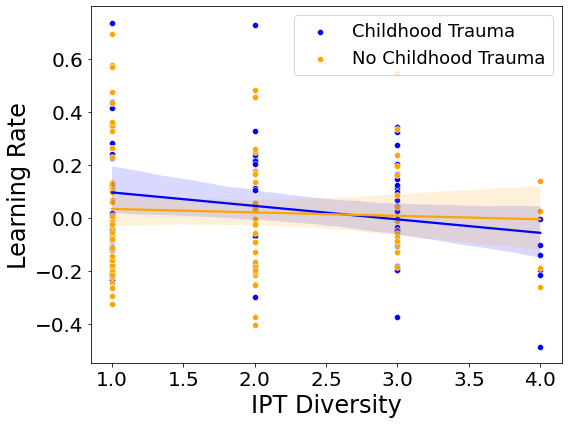

In [59]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    scatter=False, color='orange'
)

plt.xlabel('IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

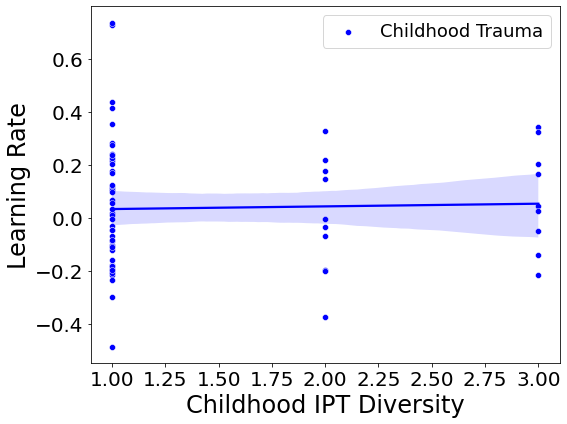

In [60]:
#CHILDHOOD IPT 


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
   
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_childhood'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_childhood'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)

plt.xlabel('Childhood IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

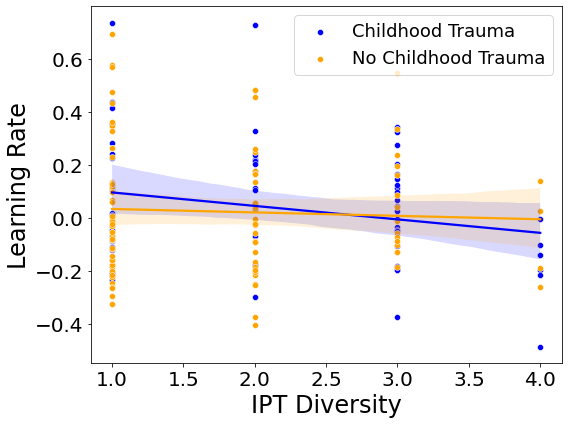

In [61]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    scatter=False, color='orange'
)

plt.xlabel('IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

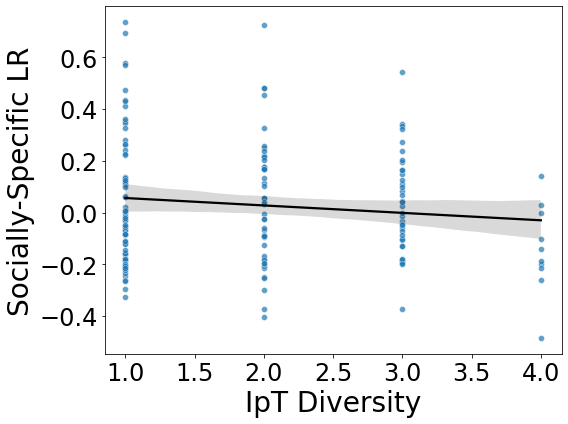

In [62]:
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
}).dropna()

regression_df = regression_df[(regression_df['interpersonal_load'] > 0)]

# Plot overall trauma load vs. socially-specific learning rate (no group split)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df['interpersonal_load'],
    y=regression_df['LR_predsoc'],
    color='#1f78b4',  # blue
    alpha=0.7
)
sns.regplot(
    x=regression_df['interpersonal_load'],
    y=regression_df['LR_predsoc'],
    scatter=False,
    color='black'
)

plt.xlabel('IpT Diversity', fontsize=28)
plt.ylabel('Socially-Specific LR', fontsize=28)
#plt.title('Trauma Load vs. Learning Rate', fontsize=32)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('trauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

<span style="font-size: 48px;">16: Bias and IPT Regressions</span>

Mean bias (no IPT): -0.023 ± 0.338
Mean bias (any IPT): -0.003 ± 0.334
Independent samples t-test: t=-0.53, p=0.599, Cohen's d=-0.062
Difference in means (Any IPT - No IPT): 0.021
95% CI for difference: [-0.056, 0.098]


C:\Users\mnand\AppData\Local\Temp/ipykernel_66384/3246269026.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


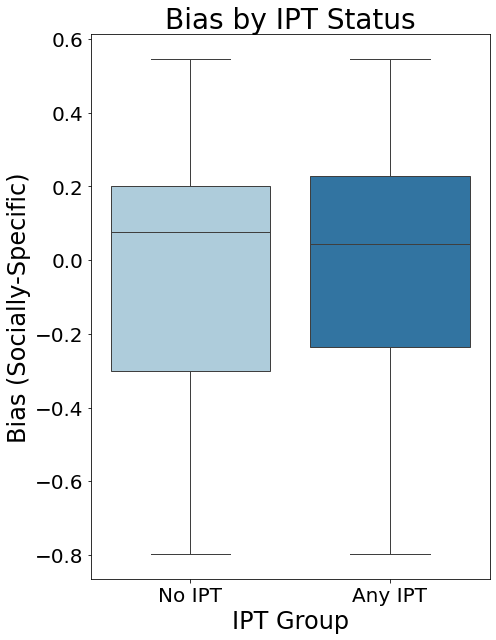

In [63]:
merged_df = pd.merge(
    allLrnSumm,
    lec_df[['interpersonal_load', 'interpersonal_childhood', 'interpersonal_load_trunc', 'interpersonal_childhood_trunc','interpersonal_chronicity']],
    left_index=True,
    right_index=True
)
valid_candidates = merged_df.index.intersection(good_candidates)
merged_df = merged_df.loc[valid_candidates]

# Group socially-specific initial offers by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjD_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjD_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean bias (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean bias (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

# Calculate 95% CI for the difference in means
mean_diff = group_any_ipt.mean() - group_no_ipt.mean()
lower_ci, upper_ci = bootstrap_mean_diff_ci(group_no_ipt, group_any_ipt)
print(f"Difference in means (Any IPT - No IPT): {mean_diff:.3f}")
print(f"95% CI for difference: [{lower_ci:.3f}, {upper_ci:.3f}]")
# Calculate SEM
# Calculate SEM
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Bias (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Bias by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('DIPT.svg', format='svg')  # <-- Export as SVG
plt.show()


In [64]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'subjD_3prm':allLrnSumm['rwsubjD_3prm'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjD_3prm")
    #print(model.summary())

def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjD_3prm")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjD_3prm")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")
run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")


#Any IPT 
run_standardized_reg(regression_df, "Any IPT")
# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjD_3prm")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")


Adult IPT with childhood IPT: std. β=-0.226, p=0.058
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjD_3prm
Adult IPT without childhood IPT: std. β=0.119, p=0.253
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjD_3prm
Adult IPT with childhood IPT w/ demos: std. β=-0.225, p=0.050
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjD_3prm
Adult IPT without childhood IPT w/ demos: std. β=0.103, p=0.340
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjD_3prm
Any IPT: std. β=-0.004, p=0.960
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjD_3prm
Childhood IPT: std. β=-0.175, p=0.145
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjD_3prm
Adulthood-only IPT: std. β=0.119, p=0.253
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjD_3prm
Chronic IPT: std. β=-0.120, p=0.262
Predictor(s): ['interpersonal_load_trunc'] | Outcom

## PRINCIPLE COMPONENT ANALYSES OF PTSD SCALES

In [65]:
print("\nComposite Score Head:")
print(qDat[['BPD_PTSD_Comp']].head())


Composite Score Head:


KeyError: "None of [Index(['BPD_PTSD_Comp'], dtype='object')] are in the [columns]"

In [ ]:
## need to do a PCA on the combined BPD and PTSD symptoms to create a composite score

#qsumm holds the questionnaire summary scores,lets take all PCL and SCID-II BPD columns
BPD_PTSD_df = qDat.loc[:, qDat.columns.str.startswith('PCL')|qDat.columns.str.startswith('SCID-II_BPD')]

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select PCL columns ending in '.2' and SCID-II BPD columns ending in '.1'
pcl_cols = []
for col in BPD_PTSD_df.columns:
    if col.startswith('PCL'):
        try:
            # Extract question number, assuming format like 'PCL5-X.Y'
            question_num = int(col.split('-')[1].split('.')[0])
            
            # For questions 9 and 11-20, take the .3 column
            if (question_num == 9 or (11 <= question_num <= 20)) and col.endswith('.3'):
                pcl_cols.append(col)
            # For other questions, take the .2 column
            elif not (question_num == 9 or (11 <= question_num <= 20)) and col.endswith('.2'):
                pcl_cols.append(col)
        except (IndexError, ValueError):
            # Ignore columns that don't match the expected format
            continue
scid_cols = [col for col in BPD_PTSD_df.columns if col.startswith('SCID-II_BPD') and col.endswith('.1')]
# Combine the selected columns into a new DataFrame for PCA
pca_input_df = BPD_PTSD_df[pcl_cols + scid_cols].copy()


# Replace NaNs with 0s as requested
pca_input_df.fillna(0, inplace=True)

# Standardize the data before applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_input_df)

pca = PCA(n_components=5) 
principal_components = pca.fit_transform(scaled_data)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

item_names = pca_input_df.columns

loading_df = pd.DataFrame(
    loadings,
    index=item_names,          # e.g. PCL5_01, SCID_BPD_03, ...
    columns=[f"PC{i+1}" for i in range(loadings.shape[1])]
)
# Define PTSD items as the first 20 rows and BPD items as the rest
ptsd_items = loading_df.index[:20]
bpd_items = loading_df.index[20:]

max_diff = -1
best_pc = None

# Iterate through the 5 principal components to find the one with the largest difference
for i in range(1, 6):
    pc = f"PC{i}"
    ptsd_mean = loading_df.loc[ptsd_items, pc].mean()
    bpd_mean  = loading_df.loc[bpd_items, pc].mean()
    diff = abs(ptsd_mean - bpd_mean)
    
    print(f"{pc}:")
    print(f"  Mean PTSD Loading: {ptsd_mean:.4f}")
    print(f"  Mean BPD Loading:  {bpd_mean:.4f}")
    print(f"  Absolute Difference: {diff:.4f}\n")

    if diff > max_diff:
        max_diff = diff
        best_pc = pc
print(f"The principal component with the largest difference is {best_pc} with a difference of {max_diff:.4f}")


# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, 
                     columns=[f'PC{i+1}' for i in range(pca.n_components)],
                     index=pca_input_df.index)

# The first principal component (PC1) is used as the composite score
qDat['BPD_PTSD_Comp'] = pc_df['PC1']
qDat['BPD_PTSD_Uniq'] = pc_df['PC2']
# --- Explained Variance ---
print("Explained variance by component: ", pca.explained_variance_ratio_)
print(f"Total variance explained by {pca.n_components} components: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Display the head of the new composite score column

#transform the data to actually work with PCA, we want each Q to have a magnitude. So we first take every PCL column ending in .2, and replace NANs with 0s for not experienced
#IMPORTANT: for now, lets only take the .1 col of SCID, but disregard .2, which is a chronicity measure


PC1:
  Mean PTSD Loading: 0.6584
  Mean BPD Loading:  0.5703
  Absolute Difference: 0.0881

PC2:
  Mean PTSD Loading: -0.2023
  Mean BPD Loading:  0.3299
  Absolute Difference: 0.5322

PC3:
  Mean PTSD Loading: -0.0110
  Mean BPD Loading:  0.0286
  Absolute Difference: 0.0396

PC4:
  Mean PTSD Loading: -0.0313
  Mean BPD Loading:  0.0449
  Absolute Difference: 0.0762

PC5:
  Mean PTSD Loading: -0.0280
  Mean BPD Loading:  0.0302
  Absolute Difference: 0.0582

The principal component with the largest difference is PC2 with a difference of 0.5322
Explained variance by component:  [0.39381389 0.08215957 0.04674719 0.04446735 0.03319851]
Total variance explained by 5 components: 60.04%


In [ ]:
#now that we have a unique and common element, lets combine these for our covariates

In [ ]:
## Learning rate correlations with PC1
from scipy.stats import pearsonr
import pandas as pd

# Create a dataframe for correlation
corr_df = pd.DataFrame({
    'PC1': qDat['BPD_PTSD_Comp'],
    'LR_social_specific': allLrnSumm['subjLR_3prm_predsoc']
})

# Filter for good candidates and drop any missing values
valid_candidates = corr_df.index.intersection(good_candidates)
corr_df = corr_df.loc[valid_candidates].dropna()

# Calculate Pearson correlation
corr, p_value = pearsonr(corr_df['PC1'], corr_df['LR_social_specific'])

print(f"Correlation between PC1 (BPD/PTSD Composite) and Socially-Specific Learning Rate:")
print(f"n = {len(corr_df)}")
print(f"Pearson's r: {corr:.3f}")
print(f"P-value: {p_value:.3g}")

Correlation between PC1 (BPD/PTSD Composite) and Socially-Specific Learning Rate:
n = 295
Pearson's r: -0.004
P-value: 0.947


In [ ]:
from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['PC1']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['LR_social_specific']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: LR_social_specific")
    #print(model.summary())

run_standardized_reg(corr_df, "PC1 predicting LR_social_specific")


PC1 predicting LR_social_specific: std. β=-0.004, p=0.947
Predictor(s): ['PC1'] | Outcome: LR_social_specific


In [ ]:
## Learning rate correlations with PC2
from scipy.stats import pearsonr
import pandas as pd

# Create a dataframe for correlation
corr_df = pd.DataFrame({
    'PC2': qDat['BPD_PTSD_Uniq'],
    'LR_social_specific': allLrnSumm['subjLR_3prm_predsoc']
})

# Filter for good candidates and drop any missing values
valid_candidates = corr_df.index.intersection(good_candidates)
corr_df = corr_df.loc[valid_candidates].dropna()

# Calculate Pearson correlation
corr, p_value = pearsonr(corr_df['PC2'], corr_df['LR_social_specific'])

print(f"Correlation between PC2 (BPD/PTSD Composite) and Socially-Specific Learning Rate:")
print(f"Pearson's r: {corr:.3f}")
print(f"P-value: {p_value:.3g}")

Correlation between PC2 (BPD/PTSD Composite) and Socially-Specific Learning Rate:
Pearson's r: 0.009
P-value: 0.879


In [ ]:

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['PC2']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['LR_social_specific']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: LR_social_specific")
    #print(model.summary())

run_standardized_reg(corr_df, "PC2 predicting LR_social_specific")

PC2 predicting LR_social_specific: std. β=0.009, p=0.879
Predictor(s): ['PC2'] | Outcome: LR_social_specific
